In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import funcs
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [7]:
data = pd.read_csv("../objects/df_imputed_not_complete_874.csv", index_col=0)
data.head()

,RID,PTHAND,PTMARRY,PTEDUCAT,PTNOTRT,PTHOME,PTPLANG,PTETHCAT,PTRACCAT,age,...,RCT29,RCT3,RCT392,RCT4,RCT5,RCT6,RCT8,RCT9,apoe,DIAGNOSIS
1,2,2,1,16,1,1,1,2,5,74.333333,...,0.2,19,1.1,21,19,15,5.6,3.0,2,Control
2,3,1,1,18,1,3,1,2,5,81.250000,...,0.1,21,1.3,16,19,19,6.9,3.5,3,AZ
3,4,1,1,10,0,1,2,1,5,67.583333,...,0.1,16,1.2,23,18,25,6.0,2.9,2,MCI
4,5,1,1,16,1,1,1,2,5,73.666667,...,0.2,16,1.0,17,24,14,5.7,3.2,2,Control
5,6,1,1,13,1,1,1,2,5,80.416667,...,0.2,19,1.1,16,19,23,5.3,4.5,2,MCI


In [9]:
outcome = data['DIAGNOSIS']
outcome = outcome.replace({"Control": 0,
                  "MCI": 1,
                  "AZ": 2})

In [11]:
data.drop(['RID', 'DIAGNOSIS'], axis = 1, inplace=True)

## Baseline model with all features

In [14]:
cat_features = [col for col in data.columns if (
    col.startswith("NX") or
    col.startswith("PX") or
    col.startswith("PT") or
    col.startswith("MH") or
    (col.startswith("GD") and col != "GDTOTAL") or
    col in ["mother", "father", "HMSCORE", "apoe"]
)]

In [22]:
X, X_test, y, y_test = train_test_split(data, outcome, test_size=0.2, random_state=43)

In [24]:
smote_over = SMOTE(random_state=44)
X, y = smote_over.fit_resample(X, y)

In [42]:
best_params_baseline = {'iterations': 2000, 
                        'learning_rate': 0.21352331247419792, 
                        'l2_leaf_reg': 1.069229165770847, 
                        'bagging_temperature': 0.5393757099444308, 
                        'random_strength': 1.9024222669286768, 
                        'depth': 6, 
                        'min_data_in_leaf': 84,
                        'random_seed': 42,
                        'loss_function': "MultiClass",
                        'colsample_bylevel': 0.6168349577162479}

In [44]:
final_model = CatBoostClassifier(**best_params_baseline, verbose=False)

In [46]:
final_model.fit(X, y)

In [48]:
predictions = final_model.predict(X_test)
predictions_proba = final_model.predict_proba(X_test)

In [50]:
funcs.metrics_merged(y_test, predictions, predictions_proba)

,Class,Recall,Precision,Specificity,NPV,AUC
0,Control,0.930233,0.851064,0.946970,0.976562,0.983968
1,MCI,0.804124,0.838710,0.807692,0.768293,0.859107
2,AD,0.657143,0.657143,0.914286,0.914286,0.888571


In [52]:
confusion_matrix(y_test, predictions)

array([[40,  3,  0],
       [ 7, 78, 12],
       [ 0, 12, 23]], dtype=int64)

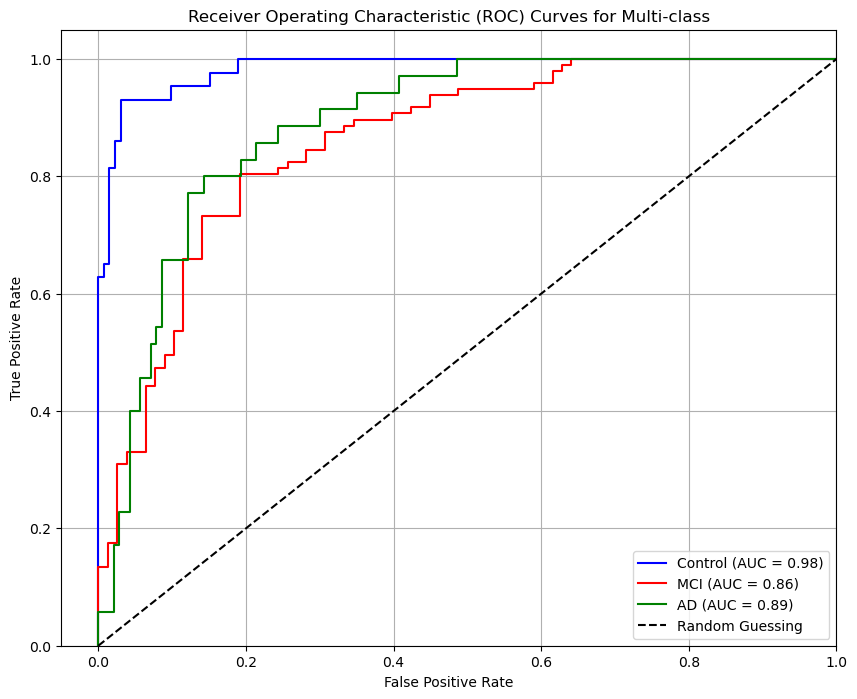

In [54]:
n_classes = len(np.unique(y_test))
class_labels = ["Control", "MCI", "AD"]
colors = ['blue', 'red', 'green']  # Define colors for the ROC curves

# Create a plot for ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test == i, predictions_proba[:, i])  # True binary labels for each class
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line for random guessing
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

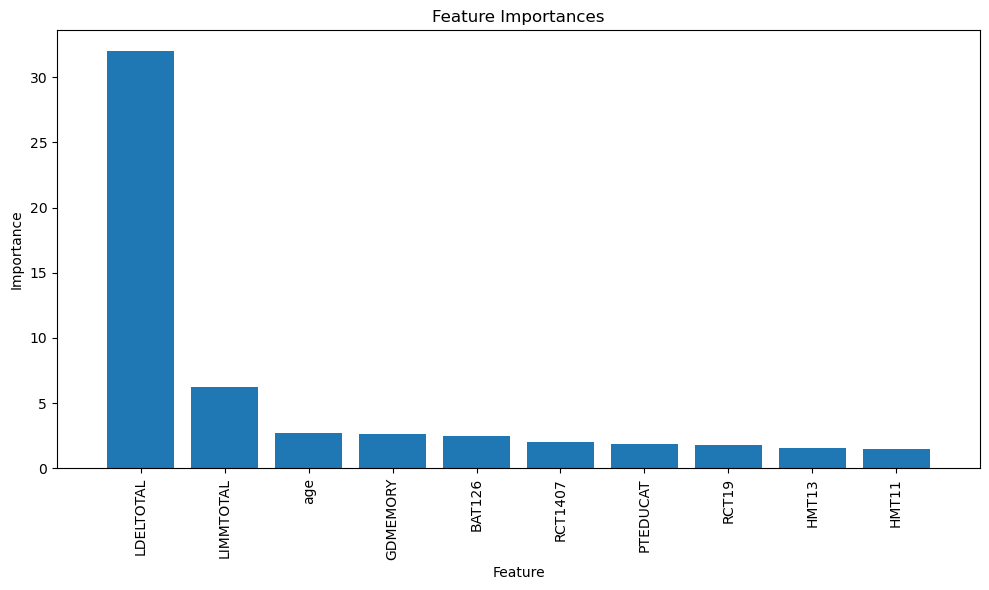

In [56]:
importances = final_model.feature_importances_
feature_names = X.columns  # If using a DataFrame, otherwise, use the appropriate feature list

# Sort feature importances
indices = np.argsort(importances)[::-1][:10]
# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), feature_names[indices], rotation=90)
plt.xlim([-1, 10])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()